# Optimization

In [3]:
import numpy as np
import ga
import pickle
import tensorflow as tf
import csv

In [4]:
# Load the machine learning model and scaler
model = tf.keras.models.load_model(r'C:\Users\krish\ai-power-converter\machine-learning\model_5_256.h5')
csv_file = r'E:\ai-power-converter\dataset\lookup_table_capacitor.csv'  # Replace 'your_csv_file.csv' with the path to your CSV file

# Define constraint values
Vol_lim = 7e-6
Delta_Vo_percent_lim = 1
Delta_IL_percent_lim = 10

# Genetic algorithm parameters
sol_per_pop = 12#8
num_parents_mating = 8#4
pop_size = (sol_per_pop, 3)  # We have 3 variables: fs, L, C

# Generate initial population
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
num_values = sol_per_pop

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

# Define mutation ranges for each parameter
mutation_ranges = [(0, 100e-6), (0, 100e-6), (0, 1000)]

# # Create arrays of discrete L, C, and fsw values within the specified ranges
L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)

# Round the values to the desired number of decimal places
L_values = np.around(L_values, decimals=6)
C_values = np.around(C_values, decimals=6)

fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values, dtype=int)

initial_population = np.column_stack((L_values, C_values, fsw_values))

# # Generate initial population
# num_values = sol_per_pop

# initial_population = []

# for _ in range(num_values):
#     # Generate random values within the specified ranges
#     new_L = np.random.uniform(L_range[0], L_range[1])
#     new_C = np.random.uniform(C_range[0], C_range[1])
#     new_fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1)
    
#     # Append the generated values to the initial population
#     initial_population.append([new_L, new_C, new_fsw])

# initial_population = np.array(initial_population)

# Function

## Calculate Fitness

In [5]:
# # Define the fitness function
# def calculate_fitness(individual):
#     # Decode the individual to get fs, L, and C values
    
#     L = individual[0]
#     C = individual[1]
#     fs = individual[2]
#     # Prepare input values for prediction
#     input_values = np.array([L, C, fs])
#     # Apply Min-Max normalization separately for each input feature
#     input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array

#     # Scale L
#     input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)

#     # Scale C
#     input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)

#     # Scale fsw
#     input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
#     # Make predictions using the model

#     # Reshape the input data to match the expected shape of the model
#     input_values_reshaped = input_values_scaled.reshape((1, -1))

#     prediction = model.predict(input_values_reshaped, verbose=0)
    
#     # Extract predictions from the model output
#     P_l_s1 = prediction[0][2]
#     P_l_s2 = prediction[0][3]
#     P_l_C = prediction[0][4]
#     P_l_L_Cu = prediction[0][5]
    
#     # Calculate the objective function value based on the given equation
#     objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C
    
#     return objective_value

def scale_input_values(L, C, fs, L_min, L_max, C_min, C_max, fsw_min, fsw_max):
    # Apply Min-Max normalization separately for each input feature
    L_scaled = (L - L_min) / (L_max - L_min)
    C_scaled = (C - C_min) / (C_max - C_min)
    fs_scaled = (fs - fsw_min) / (fsw_max - fsw_min)
    return L_scaled, C_scaled, fs_scaled

def calculate_fitness(individual):
    L, C, fs = individual
    # L_min, L_max = 30e-6, 2000e-6
    # C_min, C_max = 20e-6, 1000e-6
    # fsw_min, fsw_max = 20e3, 200e3
    # Decode the individual to get fs, L, and C values
    L_scaled, C_scaled, fs_scaled = scale_input_values(L, C, fs, L_min, L_max, C_min, C_max, fsw_min, fsw_max)
    # Make predictions using the model
    input_values_scaled = np.array([L_scaled, C_scaled, fs_scaled])
    input_values_reshaped = input_values_scaled.reshape((1, -1))
    prediction = model.predict(input_values_reshaped, verbose=0)
    
    # Extract predictions from the model output
    P_l_s1 = prediction[0][2]
    P_l_s2 = prediction[0][3]
    P_l_C = prediction[0][4]
    P_l_L_Cu = prediction[0][5]
    
    # Calculate the objective function value based on the given equation
    objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C
    
    return objective_value


## Check Constraints

In [6]:

# Define the constraints function
def check_constraints(individual):
    L = individual[0]
    C = individual[1]
    fs = individual[2]
    
    # Define the constraint values
    nearest_L, Vol_L  = search_volume(L, csv_file) # Define Vol_L based on your problem-specific requirements
    # Vol_C =  # Define Vol_C based on your problem-specific requirements
    # Prepare input values for prediction
    input_values = np.array([L, C, fs])
    # Apply Min-Max normalization separately for each input feature
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array

    # Scale L
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)

    # Scale C
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)

    # Scale fsw
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    # Make predictions using the model

    # Reshape the input data to match the expected shape of the model
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    prediction = model.predict(input_values_reshaped, verbose = 0)
    # Extract predictions from the model output
    Delta_IL_percent = prediction[0][0]
    Delta_Vo_percent = prediction[0][1]

    # Check if constraints are satisfied
    constraint1 = Vol_L  <= Vol_lim
    constraint2 = Delta_Vo_percent <= Delta_Vo_percent_lim
    constraint3 = Delta_IL_percent <= Delta_IL_percent_lim
    
    # return constraint1 and constraint2 and constraint3
    return constraint1 and constraint2 and constraint3  

## Search Volume

In [7]:
def search_volume(capacitance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        capacitance_values = []
        volume_values = []
        for row in reader:
            capacitance_values.append(float(row['Capacitance']))
            volume_values.append(float(row['Total Volume']))
        
        # Find the index of the nearest capacitance value
        nearest_idx = np.abs(np.array(capacitance_values) - capacitance).argmin()
        nearest_capacitance = capacitance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_capacitance, nearest_volume


# Genetic Algorithm

Generation :  0
Fitness
[5.317013  5.1137047 5.5260816 6.0868826 6.432824  6.699071  7.695825
 7.998335  8.291113  8.509606  8.764355  8.888518 ]
Best result :  5.1137047
Best solution :  [2.0900e-04 4.5000e-05 3.6363e+04]
Best fitness :  5.1137047
[1.7300e-04 8.6000e-05 8.4435e+04]
i'm here
[1.54100e-03 6.70000e-05 1.95757e+05]
i'm here
[1.4670e-03 9.2000e-05 7.2595e+04]
i'm here
[1.53200e-03 8.20000e-05 1.49287e+05]
i'm here
[1.69500e-03 1.39000e-04 1.94284e+05]
i'm here
Parents
[[1.46700e-03 9.20000e-05 7.25950e+04]
 [1.54100e-03 6.70000e-05 1.95757e+05]
 [1.53200e-03 8.20000e-05 1.49287e+05]
 [5.67000e-04 7.60000e-05 6.90900e+04]
 [7.46000e-04 9.20000e-05 8.54540e+04]
 [1.69500e-03 1.39000e-04 1.94284e+05]
 [1.10500e-03 1.23000e-04 1.18181e+05]
 [1.28400e-03 1.38000e-04 1.34545e+05]]
Crossover
[[1.46700e-03 6.70000e-05 1.95757e+05]
 [1.54100e-03 8.20000e-05 1.49287e+05]
 [1.53200e-03 7.60000e-05 6.90900e+04]
 [5.67000e-04 9.20000e-05 8.54540e+04]]
Mutation
[[ 1.41500e-03 -2.70000e-

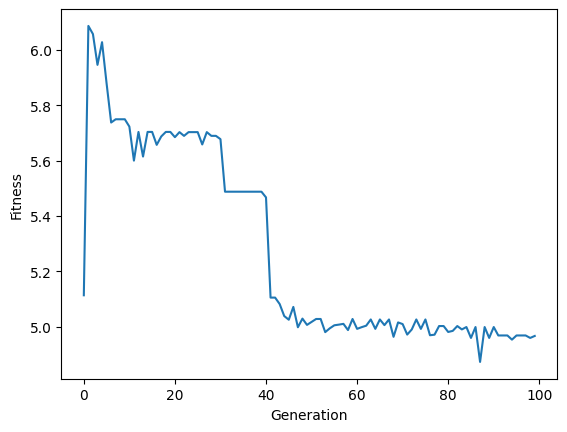

In [8]:

# Genetic Algorithm optimization
best_outputs = []
best_solutions = []  # Store the best solution for each generation
best_fitnesses = []  # Store the best fitness for each generation
num_generations = 100
new_population = initial_population

for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness_values = []
    delta_IL_percent_values = []
    delta_Vo_percent_values = []
    for individual in new_population:
        fitness_value = calculate_fitness(individual)
        fitness_values.append(fitness_value)

    fitness = np.array(fitness_values)

    
    print("Fitness")
    print(fitness)

    best_outputs.append(np.min(fitness))
    print("Best result : ", np.min(fitness))

    # Find the index of the best solution in this generation
    best_solution_idx = np.argmin(fitness)
    best_solution = new_population[best_solution_idx]
    best_solutions.append(best_solution)
    best_fitness = fitness[best_solution_idx]
    best_fitnesses.append(best_fitness)
    print("Best solution : ", best_solution)
    print("Best fitness : ", best_fitness)
    
    # Check and enforce constraints
    for i in range(sol_per_pop):
        if not check_constraints(new_population[i]):
            # Regenerate individual until it satisfies the constraints
            while not check_constraints(new_population[i]):
                # Generate all possible values within the specified range with the desired increment
                L_values_all = np.arange(L_range[0], L_range[1] + 1e-6, 1e-6)
                C_values_all = np.arange(C_range[0], C_range[1] + 1e-6, 1e-6)
                # Generate new random values for fsw, L, and C
                new_L = np.random.choice(L_values_all, 1, replace=False)
                new_C = np.random.choice(C_values_all, 1, replace=False)
                new_fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1, size=1)

                new_population[i] = [new_L[0], new_C[0], new_fsw[0]]

                print(new_population[i])
                print("i'm here")



    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 3))
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    # offspring_mutation = ga.mutation(offspring_crossover, 2)
    offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, 1)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness_values = []

for individual in new_population:
    fitness_value= calculate_fitness(individual)
    fitness_values.append(fitness_value)

fitness = np.array(fitness_values)


# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.min(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])

import matplotlib.pyplot as plt
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [ ]:

# Print the best solutions for each generation
print("Best solutions for each generation:")
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    print("Generation", i, ":", solution, "Fitness:", fitness)


# try looking for Volume

In [2]:
import csv

def search_volume(capacitance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if float(row['Capacitance']) == capacitance:
                return float(row['Total Volume'])
    return None

# Example usage:
csv_file = r'E:\ai-power-converter\dataset\lookup_table_capacitor.csv'  # Replace 'your_csv_file.csv' with the path to your CSV file
capacitance_to_search = 100e-6  # Example capacitance value to search for

total_volume = search_volume(capacitance_to_search, csv_file)
if total_volume is not None:
    print(f"Total volume for capacitance {capacitance_to_search}: {total_volume}")
else:
    print(f"No matching entry found for capacitance {capacitance_to_search}")


Total volume for capacitance 0.0001: 0.000108856


In [2]:
import csv
import numpy as np

def search_volume(capacitance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        capacitance_values = []
        volume_values = []
        for row in reader:
            capacitance_values.append(float(row['Capacitance']))
            volume_values.append(float(row['Total Volume']))
        
        # Find the index of the nearest capacitance value
        nearest_idx = np.abs(np.array(capacitance_values) - capacitance).argmin()
        nearest_capacitance = capacitance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_capacitance, nearest_volume

# Example usage:
csv_file = r'E:\ai-power-converter\dataset\lookup_table_capacitor.csv'  # Replace 'your_csv_file.csv' with the path to your CSV file
capacitance_to_search = 0.000113019  # Example capacitance value to search for

nearest_capacitance, total_volume = search_volume(capacitance_to_search, csv_file)
print(f"Nearest capacitance found: {nearest_capacitance}")
print(f"Total volume for capacitance {nearest_capacitance}: {total_volume}")


Nearest capacitance found: 0.000113019
Total volume for capacitance 0.000113019: 7.748e-06
